# Weight/Height Regression using Tensorflow

October 2018

The following experiment implements linear regression using Tensorflow, an open-sourced, scalable and flexible framework from Google Brain to create computational graphs. 

Review of regression - best fit line can be estimated mathematically through the classic y=mx+b linear function where y is the predicted variable, x the independent variable, a bias called b and m the +/- slope of the line. The errors mathematically can be represented as the average of the squares of the distances between x and predicted y on the best fit line, called RMSE or root mean squared error.

See metrics to measure performance of tasks in regression --> https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/metrics/regression.py#L183


More on Tensorflow --> https://www.tensorflow.org https://github.com/tensorflow/tensorflow

More on RMSE --> https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d

More on Linear Regression  --> https://towardsdatascience.com/simple-and-multiple-linear-regression-in-python-c928425168f9

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# import tensorflow as tf  #debug only pre-v2 
import tensorflow.compat.v1 as tf

rng = np.random



## Weight - Height dataset

The problem involves predicting human weight given human height using linear regression

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/ginobaltazar7/66daysofdata/master/Regression/weight-height.csv')

In [5]:
df.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Gender  10000 non-null  object 
 1   Height  10000 non-null  float64
 2   Weight  10000 non-null  float64
dtypes: float64(2), object(1)
memory usage: 234.5+ KB


### Visualize overall population of the dataset

In [7]:
df['Height'].values
#type(df['Height']).values

array([73.84701702, 68.78190405, 74.11010539, ..., 63.86799221,
       69.03424313, 61.94424588])

In [8]:
df[['Height']].values
#type(df[['Height']].values)

array([[73.84701702],
       [68.78190405],
       [74.11010539],
       ...,
       [63.86799221],
       [69.03424313],
       [61.94424588]])

Text(0, 0.5, 'Weight (lbs)')

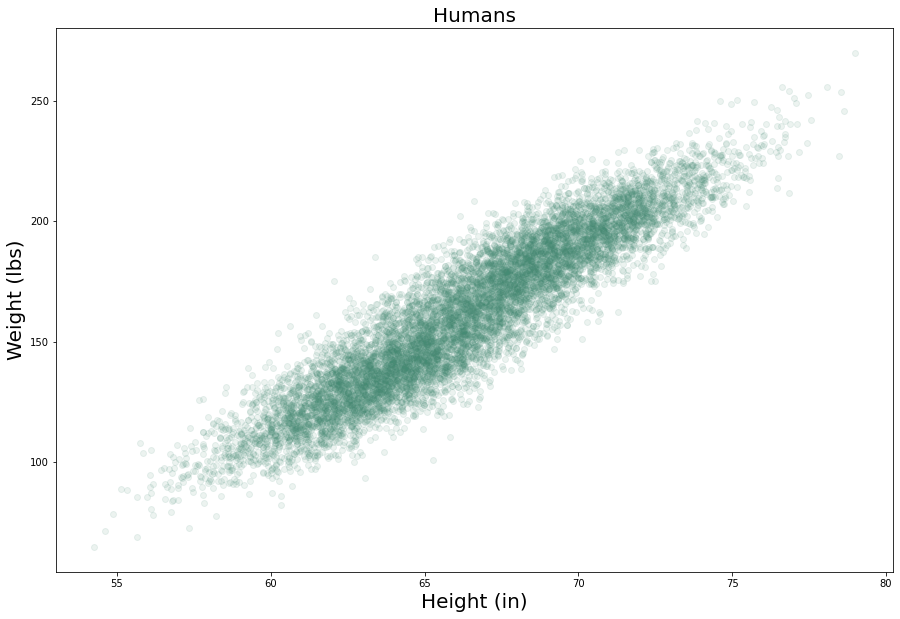

In [9]:
# per documentation - Each plot kind has a corresponding method on the DataFrame.plot accessor
plt.figure(figsize=(15,10))
plt.scatter(df['Height'], df['Weight'], alpha = 0.1, c ='#458b74')
plt.title('Humans', size=20)
plt.xlabel('Height (in)', size=20)
plt.ylabel('Weight (lbs)', size=20)

## Visualize male and female populations


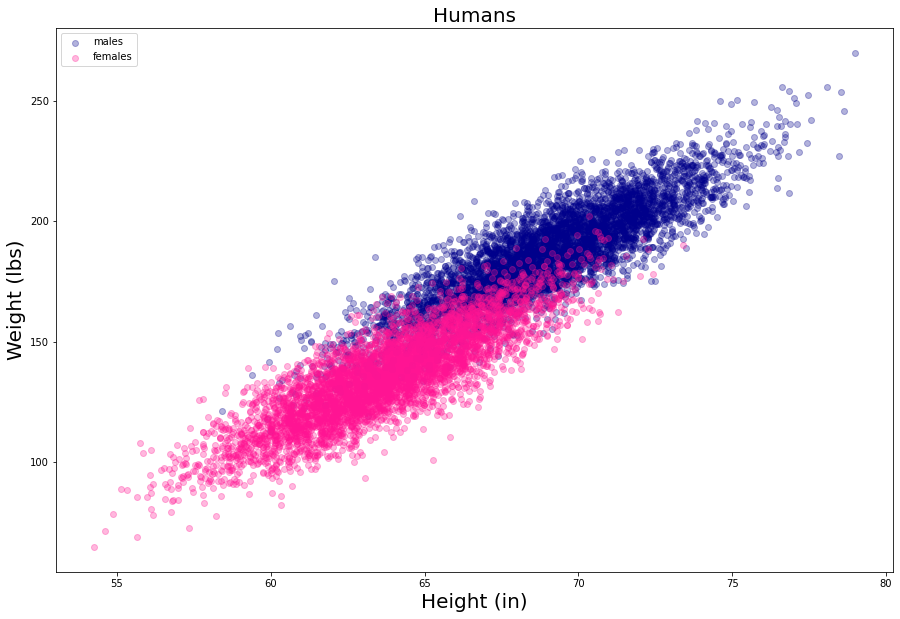

In [10]:
# males = df[df['Gender'] == 'Male']
# females = df[df['Gender'] == 'Female']

males = df.query('Gender == "Male"')
females = df.query('Gender == "Female"')

plt.figure(figsize=(15,10))
plt.scatter(males['Height'], males['Weight'], alpha = 0.3, label = 'males', c = '#00008b')
plt.scatter(females['Height'], females['Weight'], alpha = 0.3, label = 'females', c = '#ff1493')
plt.title('Humans', size = 20)
plt.xlabel('Height (in)', size = 20)
plt.ylabel('Weight (lbs)', size = 20)
plt.legend()

# Linear regression

A linear regression is a model of type where W is weight, b is bias, X is input, Y is output

    Y = X * W + b
 
Need to first set global parameters like the learning rate and the number of epochs we want to run.

In training a neural network, one epoch is really just one loop or pass of the a training set. Usually it may contain a few iterations. Because usually we divide the training set into batches, each epoch goes through the whole training set, while each iteration goes through on batch.

The learning rate essentially controls how quickly an algorithm converges (see gradient descent below as well). If the learning rate is set to high, it may wildly oscillate; too low, and it will take a very long time to converge. 

In [11]:
learning_rate = 0.00001
training_epochs = 200

In [12]:
h = df['Height'].values
w = df['Weight'].values
n_data = len(w)
ind = np.arange(n_data)


In [13]:
# split data in 2 parts (20% test / 80% train)

#n_data = len(w)

n_data = 1000
ind = np.arange(n_data)
np.random.shuffle(ind)
split_point = n_data // 5
test_ind = ind[:split_point]
train_ind = ind[split_point:]

train_X = h[train_ind]
test_X  = h[test_ind]
train_Y = w[train_ind]
test_Y  = w[test_ind]



In [14]:
train_X

array([69.47110603, 71.58012314, 67.65294548, 68.1699946 , 66.14106892,
       69.39047409, 70.54927972, 66.47376597, 66.1841085 , 73.40405852,
       68.91586364, 72.29169703, 66.4995499 , 64.72625594, 71.47610128,
       65.96579505, 70.81637062, 76.43455871, 66.72807365, 65.80731565,
       71.08008356, 69.23842719, 67.4868239 , 71.00356014, 65.973065  ,
       69.28592141, 73.78127448, 69.17985762, 68.61811055, 61.773522  ,
       73.50183962, 66.26765677, 64.45981425, 69.27281261, 67.36980864,
       65.28602551, 67.12315343, 70.55524376, 70.66199203, 71.19793782,
       69.37184333, 68.32844799, 70.86980492, 67.57715394, 72.39448041,
       66.37399493, 70.24286617, 67.14424123, 69.57720237, 69.60028264,
       65.53069597, 68.27778676, 68.49145025, 70.52322452, 68.86009031,
       67.70167966, 69.65975352, 65.84458046, 69.17357692, 69.45337621,
       66.24506481, 66.53430651, 71.61517875, 61.97273588, 69.66372523,
       69.34345396, 73.05634425, 71.85112915, 71.6055731 , 71.83

In [15]:
train_Y

array([205.97791017, 205.34759621, 188.88986454, 185.25310988,
       165.40454534, 180.17547276, 191.31881083, 175.9473678 ,
       172.63761154, 192.73240468, 183.9477889 , 202.10437163,
       163.30952831, 143.3475655 , 195.39261758, 186.22543073,
       197.19840156, 228.87299064, 155.89954133, 163.85182488,
       209.85355364, 197.41209136, 164.29524125, 194.32260136,
       187.65837914, 178.78954798, 221.24009576, 192.01433541,
       187.50684316, 149.51483917, 225.97221832, 170.25017865,
       161.37877321, 202.29876015, 176.63616357, 161.42008166,
       147.53795616, 198.4602486 , 217.95188261, 210.13452904,
       173.43016961, 177.9847286 , 205.86393452, 181.43271301,
       208.43650904, 167.78439103, 192.79611256, 175.67919018,
       204.16412548, 176.59488856, 172.11431195, 195.18993016,
       173.42396035, 207.53283852, 169.55682078, 159.2865106 ,
       209.5204246 , 170.7923569 , 195.2375293 , 219.26170667,
       154.58868959, 166.371258  , 209.67077388, 140.27

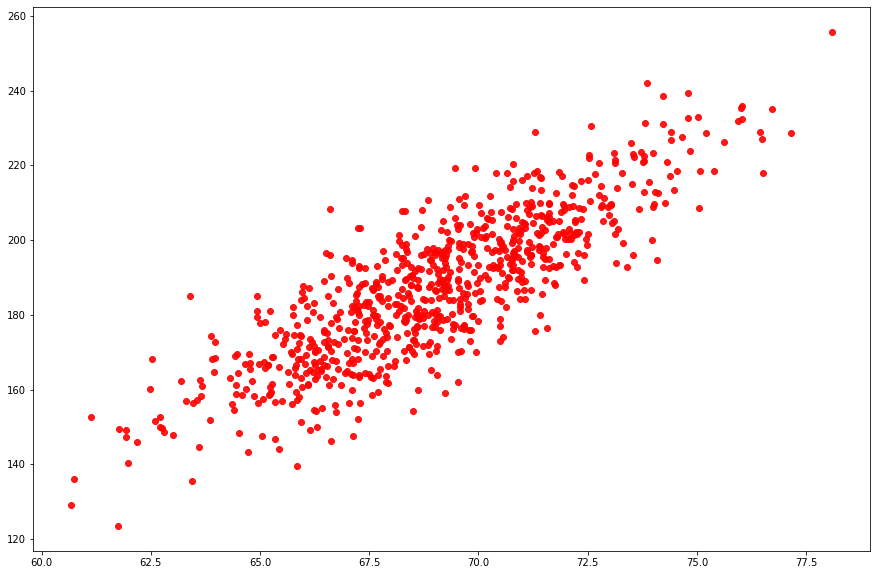

In [16]:
plt.figure(figsize=(15,10))
plt.scatter(train_X, train_Y, alpha = 0.9, c = 'red')

# Tensorflow placeholders, model vars, linear model
- define input placeholders, assign them to variables named X and Y
- define model variables W and b and assign them names W and b
- construct the linear model of the form: pred = X * W + b
- define the cost as the mean of the squared error between Y and pred, using the function tf.reduce_mean

In [19]:
# tf Graph Input using tf.compat.v1.placeholder

tf.disable_v2_behavior() 
X = tf.compat.v1.placeholder("float", name='X')
Y = tf.compat.v1.placeholder("float", name='Y')

Instructions for updating:
non-resource variables are not supported in the long term


In [20]:
# Set model weights
W = tf.Variable(1.0, name="W")
b = tf.Variable(0.0, name="b")

In [21]:
# Construct a linear model 
pred = tf.add(tf.multiply(X, W), b)

In [22]:
# Mean squared error cost function
# cost = tf.reduce_mean(tf.pow(pred-Y, 2))
cost = tf.reduce_mean(tf.square(pred-Y))
# cost = tf.reduce_mean(tf.squared_difference(pred, Y))

In [23]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(pred, feed_dict={X:train_X}))

[69.47111  71.580124 67.65295  68.17     66.14107  69.39047  70.54928
 66.47376  66.184105 73.40406  68.91586  72.291695 66.49955  64.72626
 71.476105 65.9658   70.81637  76.434555 66.72807  65.80731  71.080086
 69.23843  67.486824 71.00356  65.97307  69.28592  73.78127  69.179855
 68.61811  61.77352  73.50184  66.267654 64.459816 69.27281  67.36981
 65.286026 67.12315  70.555244 70.661995 71.19794  69.37184  68.328445
 70.869804 67.577156 72.39448  66.37399  70.24287  67.14424  69.5772
 69.60028  65.53069  68.27779  68.49145  70.523224 68.86009  67.70168
 69.65975  65.84458  69.17358  69.45338  66.24506  66.53431  71.61518
 61.972736 69.66373  69.34345  73.05634  71.85113  71.605576 71.83317
 69.982216 66.55723  64.739815 69.16438  73.78664  67.230774 66.79579
 69.33874  67.7877   68.287636 65.838394 62.532253 68.6038   65.11851
 66.26282  75.05967  71.2952   72.34159  71.5712   70.05218  68.78508
 70.877045 67.121506 63.596455 68.96088  68.515526 67.09759  68.59766
 78.09587  65.9033

# Optimizer

Minimize the loss using the Tensorflow's Gradient Descent Optimizer.
The gradient descent is really just the derivative of the loss function (cost) - conceptually think of it as a way to find the minimum point on a function by following the descent of its slope.

More on Gradient Descent via Andrew Ng --> https://www.coursera.org/lecture/machine-learning/gradient-descent-intuition-GFFPB

In [24]:
# Gradient descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

# Run the Model

In [25]:
# Initialize the variables
init = tf.global_variables_initializer()

In [26]:
training_epochs = 200

In [27]:
learning_rate

1e-05

In [28]:
train_Y

array([205.97791017, 205.34759621, 188.88986454, 185.25310988,
       165.40454534, 180.17547276, 191.31881083, 175.9473678 ,
       172.63761154, 192.73240468, 183.9477889 , 202.10437163,
       163.30952831, 143.3475655 , 195.39261758, 186.22543073,
       197.19840156, 228.87299064, 155.89954133, 163.85182488,
       209.85355364, 197.41209136, 164.29524125, 194.32260136,
       187.65837914, 178.78954798, 221.24009576, 192.01433541,
       187.50684316, 149.51483917, 225.97221832, 170.25017865,
       161.37877321, 202.29876015, 176.63616357, 161.42008166,
       147.53795616, 198.4602486 , 217.95188261, 210.13452904,
       173.43016961, 177.9847286 , 205.86393452, 181.43271301,
       208.43650904, 167.78439103, 192.79611256, 175.67919018,
       204.16412548, 176.59488856, 172.11431195, 195.18993016,
       173.42396035, 207.53283852, 169.55682078, 159.2865106 ,
       209.5204246 , 170.7923569 , 195.2375293 , 219.26170667,
       154.58868959, 166.371258  , 209.67077388, 140.27

Epoch: 0020 cost= 190.579544067 W= 2.7045374 b= -0.08928051
Epoch: 0040 cost= 190.493942261 W= 2.7062056 b= -0.20316783
Epoch: 0060 cost= 190.408386230 W= 2.707873 b= -0.31699535
Epoch: 0080 cost= 190.322891235 W= 2.70954 b= -0.43076137
Epoch: 0100 cost= 190.237533569 W= 2.7112057 b= -0.5444699
Epoch: 0120 cost= 190.152343750 W= 2.7128701 b= -0.6581106
Epoch: 0140 cost= 190.067092896 W= 2.7145345 b= -0.77169365
Epoch: 0160 cost= 189.982025146 W= 2.7161975 b= -0.88521975
Epoch: 0180 cost= 189.897064209 W= 2.7178595 b= -0.99869347
Epoch: 0200 cost= 189.812149048 W= 2.719521 b= -1.1120865
Optimization Finished!
Training cost= 189.81215 W= 2.719521 b= -1.1120865


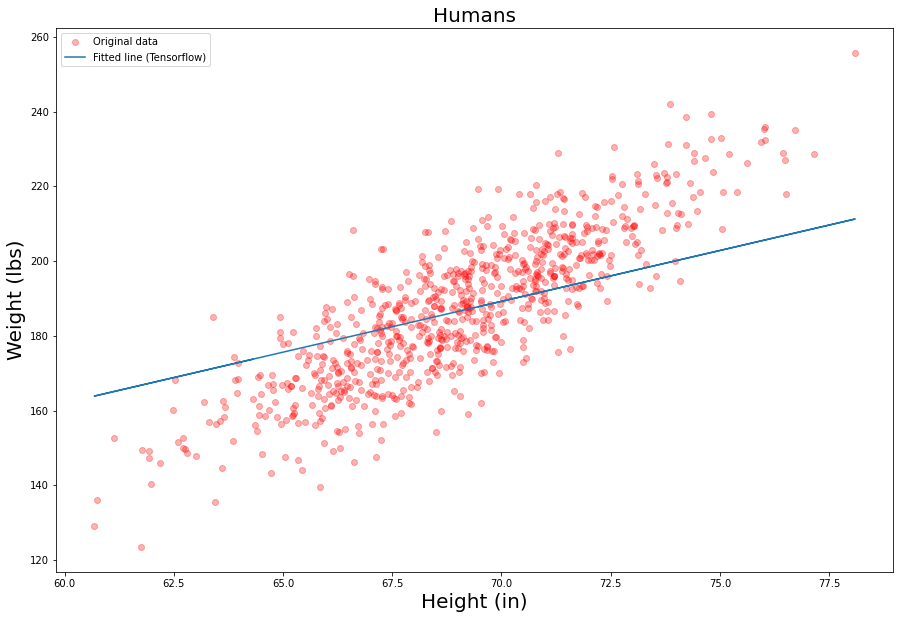

In [29]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)

    # Fit all training data
    for epoch in range(training_epochs):
        for (x, y) in zip(train_X, train_Y): # enter 1 data point at a time into the graph
            sess.run(optimizer, feed_dict={X: x, Y: y}) # feed as a dictionary

        #Display logs per epoch step to see progression of the training
        if (epoch+1) % 20 == 0:
            c = sess.run(cost, feed_dict={X: train_X, Y:train_Y})
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c), \
                  "W=", sess.run(W), "b=", sess.run(b))

    print("Optimization Finished!")
    training_cost = sess.run(cost, feed_dict={X: train_X, Y: train_Y})
    print("Training cost=", training_cost, "W=", sess.run(W), "b=", sess.run(b))

    #Graphic display
    plt.figure(figsize=(15,10))
    plt.plot(train_X, train_Y, 'ro', alpha = 0.3, label='Original data')
    plt.plot(train_X, sess.run(W) * train_X + sess.run(b), label='Fitted line (Tensorflow)')
    plt.title('Humans', size = 20)
    plt.xlabel('Height (in)', size = 20)
    plt.ylabel('Weight (lbs)', size = 20)
    plt.legend()
    
    plt.show()

# Compare to Scikit's Linear Regression

In [30]:
from sklearn.linear_model import LinearRegression

In [31]:
# create instance of linear regression class
regr = LinearRegression()

x = df[['Height']].values
y = df['Weight']

# split data in 2 parts (20% test / 80% train)
n_data = len(y)
#n_data = 100
ind = np.arange(n_data)
np.random.shuffle(ind)
split_point = n_data // 5
test_ind = ind[:split_point]
train_ind = ind[split_point:]

train_X = x[train_ind]
test_X  = x[test_ind]
train_Y = y[train_ind]
test_Y  = y[test_ind]


regr.fit(train_X, train_Y)

LinearRegression()

In [32]:
# The coefficients
print("Slope: %.2f" % regr.coef_)
print("Intercept: %.2f" % regr.intercept_)

Slope: 7.73
Intercept: -351.60


In [33]:
# The mean square error or MSE
# average of the square of the distances to the best fit line through the data points
print("Residual sum of squares: %.2f"
      % np.mean((regr.predict(test_X) - test_Y) ** 2))

Residual sum of squares: 156.37


In [34]:
# Explained variance score: 1 is perfect prediction 
# or the R-squared - the proportion of the variance in the dependent variable that is predictable 
# from the independent variable
print('Variance score: %.2f' % regr.score(test_X, test_Y))

Variance score: 0.85


In [35]:
regr.predict(df[['Height']].values[ind[:split_point]])

array([178.78524846, 166.4375509 , 202.6412742 , ..., 147.33188521,
       156.6505611 , 173.29490278])

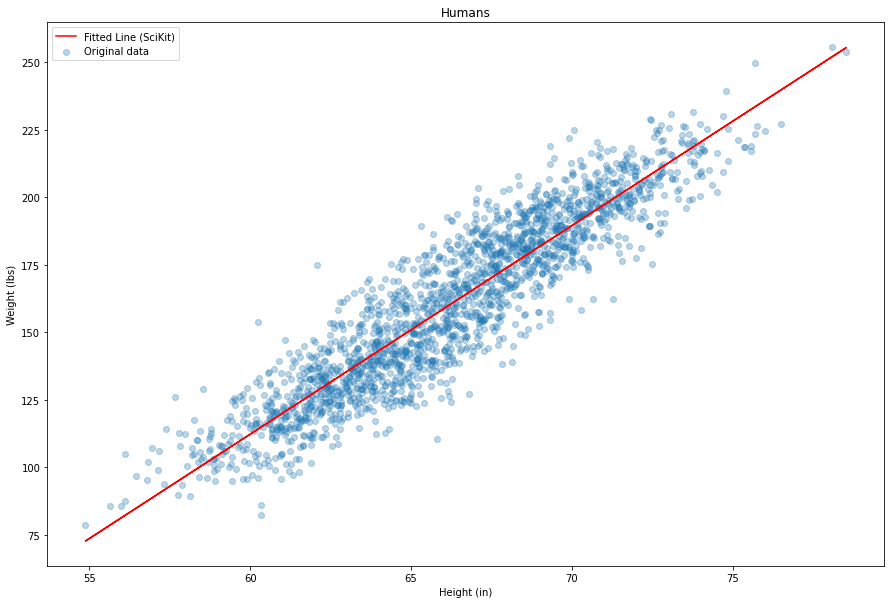

In [36]:

plt.figure(figsize=(15,10))
plt.scatter(test_X, test_Y, alpha = 0.3, label='Original data')
plt.plot(test_X, regr.predict(df[['Height']].values[ind[:split_point]]), color = 'red', label='Fitted Line (SciKit)')
plt.title('Humans')
plt.xlabel('Height (in)')
plt.ylabel('Weight (lbs)')
plt.legend()
plt.show()

# Observations

The Tensorflow model's execution was much slower, and varying the learning rate introduced interesting results. For example, if the learning rate was set too high, the model's training would fail, and produce NaN's during the computation of cost. Still, the resulting fitting line is not bad even with the reduced number of epochs and the reduced size of the training set, both of which had to be reduced to get the model to run faster. 

*Copyright &copy; 2020 Gino Baltazar All rights reserved.*